<a href="https://colab.research.google.com/github/kuzmichye/Covid_cv/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yegorkuzmenko
Your Kaggle Key: ··········


100%|██████████| 158M/158M [00:01<00:00, 91.7MB/s]


In [25]:

from keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


In [6]:
height,width = 180,180
batch_size = 32
training_directory = '/content/covid19-image-dataset/Covid19-dataset/train'
testing_directory = '/content/covid19-image-dataset/Covid19-dataset/test'

def get_data(path):
    generator = ImageDataGenerator(rescale=1./255.)
    data = generator.flow_from_directory(
        path,
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=batch_size,
        shuffle=True,
        seed=122,
        class_mode='binary',
        target_size=(height, width),
    )
    return data


training_data = get_data(training_directory)
testing_data = get_data(testing_directory)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [26]:
class_names = list(training_data.class_indices.keys())
class_names

['Normal', 'Viral Pneumonia', 'Covid']

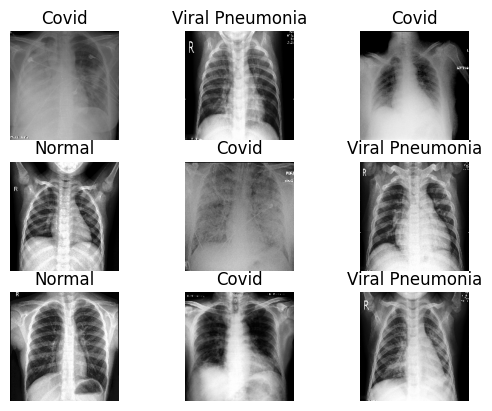

In [27]:
images, labels = next(training_data)

# Распечатываем изображения и соответствующие им значения из class_names
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.show()

In [28]:
def get_augmented_data(path):
  data = ImageDataGenerator(
      rescale = 1./255,
      zoom_range = 0.1,
      rotation_range = 30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True
  ).flow_from_directory(
       path,
        batch_size=batch_size,
        seed=122,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1, 'Covid': 2}
    )
  return data
augmented_training_data = get_augmented_data(training_directory)

Found 251 images belonging to 3 classes.


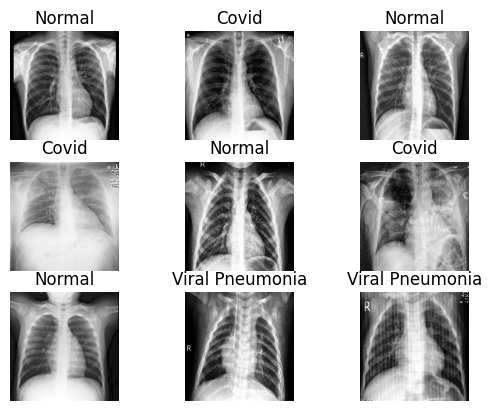

In [29]:
images, labels = next(training_data)

# Распечатываем изображения и соответствующие им значения из class_names
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.show()

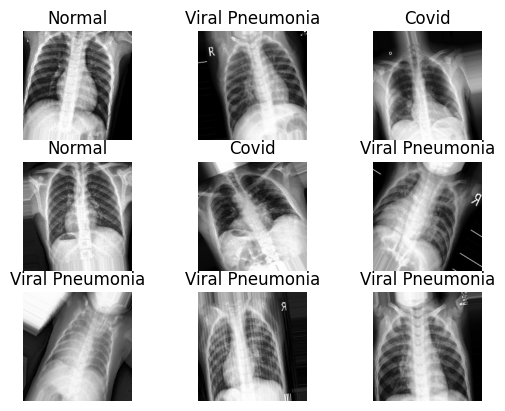

In [30]:
images, labels = next(augmented_training_data)

# Распечатываем изображения и соответствующие им значения из class_names
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.show()


In [31]:
def build_nn(base_nn):
  tf.keras.backend.clear_session()
  input_shape = (height, width, 3)
  base = base_nn(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
  base.trainable = False
  nn = Sequential()
  nn.add(base)
  nn.add(GlobalAveragePooling2D())
  nn.add(Flatten())
  nn.add(Dense(256, activation='relu'))
  nn.add(Dropout(0.5))
  nn.add(Dense(256, activation='relu'))
  nn.add(Dropout(0.5))
  nn.add(Dense(3, activation='softmax'))
  nn.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(0.001),metrics=['acc'])
  return nn

model =  build_nn(VGG16)
print(model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [32]:
def fit_nn(nn, save_path, train_data, test_data):
    checkpoint = ModelCheckpoint(save_path, monitor='acc', verbose=1, mode='max',save_best_only=True)
    fitting = nn.fit(
        train_data,
        validation_data = test_data,
        epochs=50,
        shuffle=False,
        verbose=True,
        callbacks=[checkpoint])
    return fitting

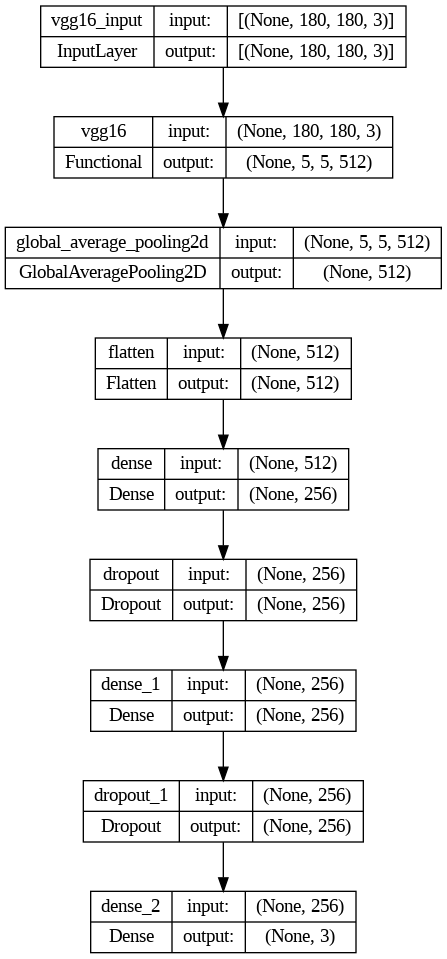

In [34]:

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [35]:
vgg16 = build_nn(VGG16)

In [36]:
fitting_vgg16 = fit_nn(vgg16, 'model/vgg16', augmented_training_data,testing_data)


Epoch 1: acc improved from -inf to 0.40239, saving model to model/vgg16
8/8 [==============================] - 149s 19s/step - loss: 1.1700 - acc: 0.4024 - val_loss: 0.9741 - val_acc: 0.4545
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.0413 - acc: 0.4781 
Epoch 2: acc improved from 0.40239 to 0.47809, saving model to model/vgg16
8/8 [==============================] - 127s 16s/step - loss: 1.0413 - acc: 0.4781 - val_loss: 0.8542 - val_acc: 0.6667
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.8440 - acc: 0.6215 
Epoch 3: acc improved from 0.47809 to 0.62151, saving model to model/vgg16
8/8 [==============================] - 133s 16s/step - loss: 0.8440 - acc: 0.6215 - val_loss: 0.7268 - val_acc: 0.8182
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.8184 - acc: 0.6255 
Epoch 4: acc improved from 0.62151 to 0.62550, saving model to model/vgg16
8/8 [==============================] - 143s 18s/step - loss: 0.8184 - acc: 0.6255

KeyboardInterrupt: 